In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda")

# Import our models. The package will take care of downloading the models automatically

model_name = "NousResearch/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/workspace/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.83s/it]
/workspace/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/workspace/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in samp

In [2]:
from datasets import load_dataset

dataset = load_dataset("cais/mmlu", 'elementary_mathematics')

In [3]:
# for p in model.parameters():
#     p.requires_grad = False

# model.model.layers[0].self_attn.v_proj.weight.zero_()
# model.model.layers[1].self_attn.v_proj.weight.zero_()
# model.model.layers[-1].self_attn.v_proj.weight.zero_()

In [4]:
import numpy as np

sentence = """
<s>[INST] <<SYS>>
Answer the following question.
<</SYS>>
"A poultry egg is dissected in science class. What is the clear, thick fluid inside the poultry egg that serves as protection for the embryo?"
A. Shell
B. Yolk
C. Yolk sac
D. Albumen
[/INST]
The correct answer is: D
""".strip()

# Q Layer shape:
# Batch Size x Seq Len x Head Size x Dim Per Head

with torch.no_grad():
    input = tokenizer(sentence, return_tensors="pt").to(device)
    output = model(
        **input,
        output_attentions=True)

target = "D"
target_id = -1

# searching for the target token in reverse

for i in range(input.input_ids.shape[1] - 1, -1, -1):
    if target in tokenizer.decode([input.input_ids[0, i].item()]):
        target_id = i
        break

assert target_id != -1
print(target_id)


weights = np.zeros((len(output.attentions), input.input_ids.shape[1]))
for i in range(len(output.attentions)):
    weight = output.attentions[i][0, :, target_id - 1, :]
    weight = torch.sum(weight, axis=0) / 32
    weights[i, :] = weight.cpu().numpy()

labels = [tokenizer.decode([i]) for i in input.input_ids[0].cpu().numpy()]

90


In [5]:
# output.logits[0, target_id].shape
# top 10
top_token_ids = torch.topk(output.logits[0, target_id - 1], 10).indices.cpu().numpy()
top_tokens = [tokenizer.decode([i]) for i in top_token_ids]

print(top_tokens)

['\n', 'B', '(', 'B', '', 'A', '</s>', '**', 'Б', '[']


In [6]:
answers = ['A', 'B', 'C', 'D']
logits = output.logits[0, target_id - 1, :]
probs = torch.softmax(logits, dim=-1).cpu().numpy()
for answer in answers:
    token = tokenizer.encode(answer)[1]
    prob = probs[token] * 100
    print(f"{answer}: {prob:.3f}%")

A: 0.000%
B: 1.218%
C: 0.000%
D: 0.000%


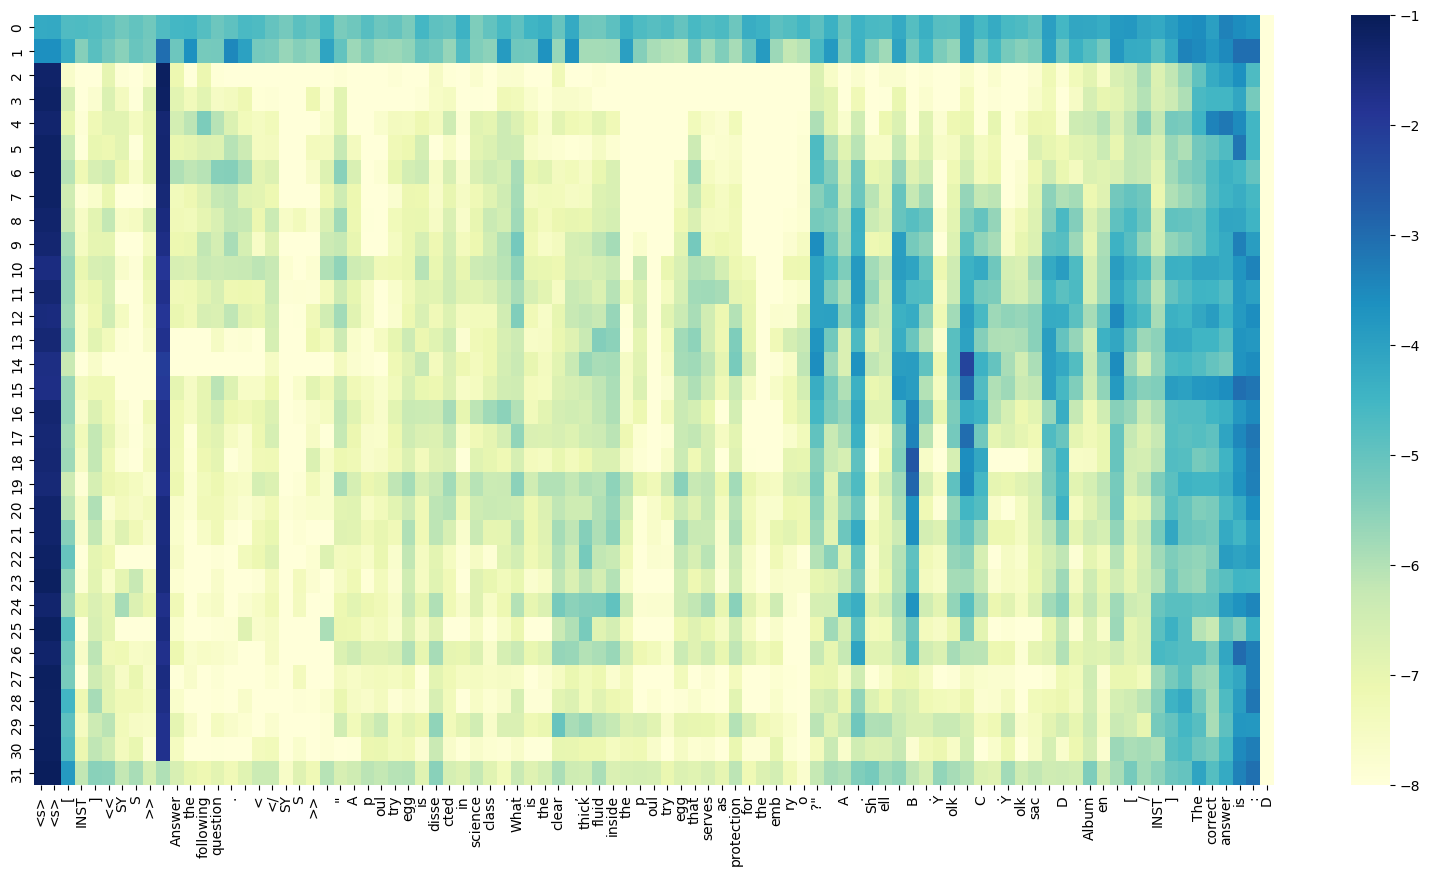

In [9]:
# visualize attention weights
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
weights = np.clip(weights, 1e-6, 1)
log_weights = np.log(weights)

ax = sns.heatmap(log_weights, cmap="YlGnBu", xticklabels=labels, vmin=-8, vmax=-1)